In [2]:
import random
import os, math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde
from utils import *

plt.rcParams["font.family"] = "DejaVu Serif"    

plt.rcParams.update({
    "font.size": 14,          
    "axes.titlesize": 16,     
    "axes.labelsize": 14,     
    "xtick.labelsize": 12,    
    "ytick.labelsize": 12,
    "legend.fontsize": 12,    
    "figure.titlesize": 18,   
})   

n = 500; xi = 200
np.random.seed(1234)

## MLE estimate and Bootstrap CI around it

In [4]:
def point_estimate_gaussians(x):
    """Estimate changepoint and segment means under a 1D Gaussian mean-shift model."""
    x = np.asarray(x, dtype=float)
    n = x.size
    csum = np.cumsum(x)
    
    tau_hat = int(np.argmin(csum[:-1]) + 1)   # MLE changepoint via cumulative sum minimum
    theta_0_hat = np.mean(x[:tau_hat])
    theta_1_hat = np.mean(x[tau_hat:])
    
    return tau_hat, theta_0_hat, theta_1_hat


def bootstrap_CI(x, B=1000, alpha=0.1, random_state=None):
    """Bootstrap CI and pointwise p-values for changepoint location (Gaussian mean-shift)."""
    rng = np.random.default_rng(random_state)
    x = np.asarray(x, dtype=float)
    n = x.size

    tau_hat, theta_0_hat, theta_1_hat = point_estimate_gaussians(x)

    # residuals centered around 0
    left_errors, right_errors = x[:tau_hat]-theta_0_hat, x[tau_hat:]-theta_1_hat
    errors = np.concatenate([left_errors, right_errors]) - np.mean(np.concatenate([left_errors, right_errors]))

    # bootstrap over resampled residuals
    taus_boot = np.empty(B, dtype=int)
    for b in range(B):
        e_boot = rng.choice(errors, size=n, replace=True)
        y_boot = e_boot.copy()
        y_boot[:tau_hat] += theta_0_hat
        y_boot[tau_hat:] += theta_1_hat
        taus_boot[b], _, _ = point_estimate_gaussians(y_boot)

    # bootstrap CI for tau
    lo = int(np.quantile(taus_boot, alpha/2, method="nearest"))
    hi = int(np.quantile(taus_boot, 1 - alpha/2, method="nearest"))

    # compute two-sided p-values based on bootstrap deviations
    abs_dev_boot = np.abs(taus_boot - tau_hat)
    p_vals = np.empty(n - 1, dtype=float)
    for t in range(1, n):
        d = abs(t - tau_hat)
        p_vals[t - 1] = (1 + np.sum(abs_dev_boot >= d)) / (B + 1)

    return lo, hi, p_vals


# Model 1: Gaussian Setting

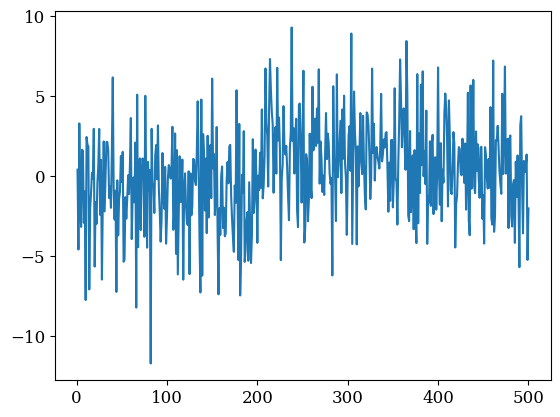

In [5]:
timeseries1 = np.concatenate([np.random.normal(-1, 3, xi), np.random.normal(1, 3, n - xi)])
time_indices = np.arange(1, n + 1)

plt.plot(time_indices, timeseries1)
plt.show()

#### get bootstrap p-values and a point estimate

In [6]:
_,_,boot_pval1 = bootstrap_CI(timeseries1, B=500, alpha=0.1)
pt_estimate1 = np.argmax(boot_pval1)+1
print(pt_estimate1)

202


#### get CONCH p-values

In [7]:
# ---- CPP score for CONCH ----- #
def CI_pval_score(x, t, pt_est=pt_estimate1):
    n = x.size
    lo, hi, pvals = bootstrap_CI(x, B=500, alpha=0.1)
    return (pvals[t-1]/pvals[pt_est-1])

In [8]:
# CONCH p-values
p_values_conch1 = compute_p_values(
    timeseries1,
    score_fn=CI_pval_score,
    nperm=100,
    random_state=420,
    n_jobs=-1,         
    backend="loky",   
    verbose=10,       
)

computing CONCH p-values:   0%|          | 0/499 [00:00<?, ?it/s]

#### confidence sets

In [9]:
print(confidence_set(boot_pval1, 0.05))
print(confidence_set(p_values_conch1, 0.05))

[182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222]
[199, 200, 201, 202, 203]


#### visualization

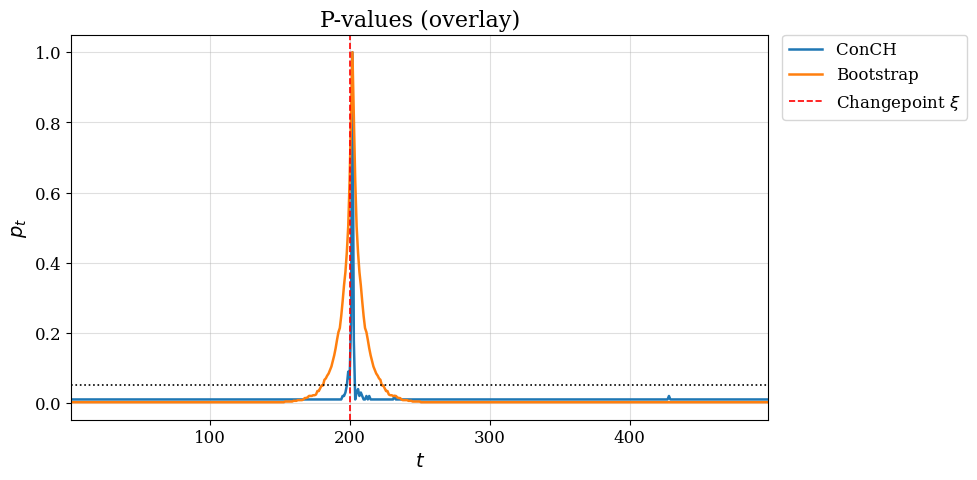

In [19]:
series = [
    ("ConCH ", p_values_conch1),
    ("Bootstrap", boot_pval1),
]

alpha = 0.05
fig, ax = plt.subplots(figsize=(9, 5))
colors = ["tab:blue", "tab:orange"] 

for (label, pvals), c in zip(series, colors):
    t = np.arange(1, len(pvals) + 1)
    ax.plot(t, pvals, color=c, linestyle="-", linewidth=1.8, label=label)


ax.axvline(x=xi, linestyle="--", color="red", linewidth=1.2,
           label=rf"Changepoint $\xi$")
ax.axhline(y=alpha, linestyle=":", color="black", linewidth=1.2)

max_len = max(len(pv) for _, pv in series)
ax.set_xlim(1, max_len)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$p_t$")
ax.set_title("P-values (overlay)")
ax.grid(True, alpha=0.4)
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.0, frameon=True)
plt.show()
plt.close(fig)


# Model 2: Laplace setting

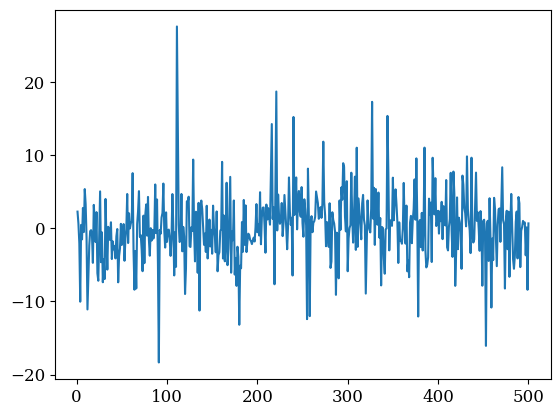

In [11]:
timeseries2 = np.concatenate([np.random.laplace(-1, 3, xi), np.random.laplace(1, 3, n - xi)])
time_indices = np.arange(1, n + 1)

plt.plot(time_indices, timeseries2)
plt.show()

#### get bootstrap p-values and a point estimate

In [12]:
_,_,boot_pval2 = bootstrap_CI(timeseries2, B=500, alpha=0.1)
pt_estimate2 = np.argmax(boot_pval2)+1,
print(pt_estimate2) 

(197,)


#### get CONCH p-values

In [13]:
# ---- CPP score for CONCH ----- #
def CI_pval_score(x, t, pt_est=pt_estimate2[0]):
    n = x.size
    lo, hi, pvals = bootstrap_CI(x, B=500, alpha=0.1)
    return (pvals[t-1]/pvals[pt_est-1])


In [14]:
# CONCH p-values
p_values_conch2 = compute_p_values(
    timeseries2,
    score_fn=CI_pval_score,
    nperm=100,
    random_state=420,
    n_jobs=-1,         
    backend="loky",   
    verbose=10,       
)

computing CONCH p-values:   0%|          | 0/499 [00:00<?, ?it/s]

#### confidence sets

In [16]:
print(confidence_set(boot_pval2, 0.05))
print(confidence_set(p_values_conch2, 0.05))

[132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262]
[192, 197, 198, 199, 201, 210]


#### visualization

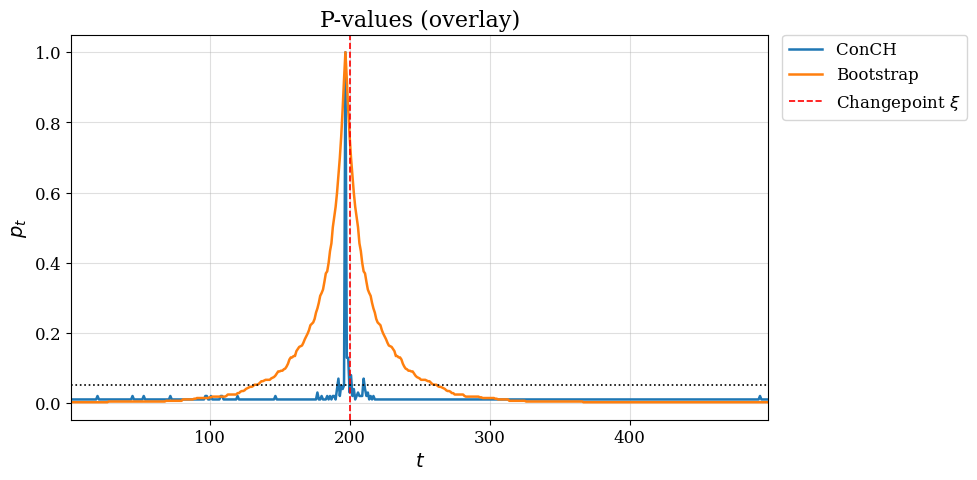

In [17]:
series = [
    ("ConCH ",         p_values_conch2),
    ("Bootstrap", boot_pval2),
]

alpha = 0.05
fig, ax = plt.subplots(figsize=(9, 5))
colors = ["tab:blue", "tab:orange"]  

for (label, pvals), c in zip(series, colors):
    t = np.arange(1, len(pvals) + 1)
    ax.plot(t, pvals, color=c, linestyle="-", linewidth=1.8, label=label)
ax.axvline(x=xi, linestyle="--", color="red", linewidth=1.2,
           label=rf"Changepoint $\xi$")
ax.axhline(y=alpha, linestyle=":", color="black", linewidth=1.2)

max_len = max(len(pv) for _, pv in series)
ax.set_xlim(1, max_len)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$p_t$")
ax.set_title("P-values (overlay)")
ax.grid(True, alpha=0.4)
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.0, frameon=True)
plt.show()
plt.close(fig)

## side by side plotting

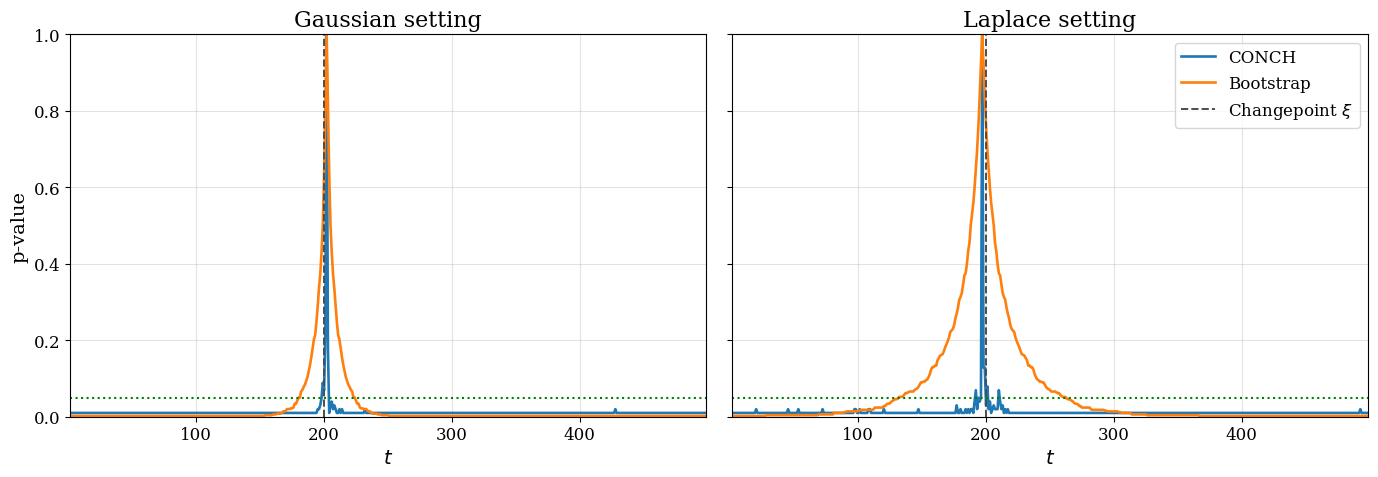

Saved figure to: ../images/pvals_calibrated_pair.pdf


In [18]:
series1 = [
    ("CONCH",    p_values_conch1),
    ("Bootstrap", boot_pval1),
]
series2 = [
    ("CONCH",    p_values_conch2),
    ("Bootstrap", boot_pval2),
]

alpha = float(alpha)
xi = int(xi)

# ---- Figure with two side-by-side subplots ----
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
titles = ["Gaussian setting", "Laplace setting"]
colors = ["tab:blue", "tab:orange"]

for ax, series, title in zip(axes, [series1, series2], titles):
    for (label, pvals), c in zip(series, colors):
        t = np.arange(1, len(pvals) + 1)
        ax.plot(t, pvals, color=c, lw=1.9, label=label)

    # Changepoint & threshold lines
    ax.axvline(x=xi, ls="--", color="#4D4D4D", lw=1.4, label=rf"Changepoint $\xi$")
    ax.axhline(y=alpha, ls=":",  color="green", lw=1.5)

    max_len = max(len(pv) for _, pv in series)
    ax.set_xlim(1, max_len)
    ax.set_ylim(0, 1)
    ax.set_xlabel(r"$t$")
    ax.set_title(title)
    ax.grid(True, alpha=0.35)

axes[0].set_ylabel("p-value")
axes[1].legend(loc="upper right", frameon=True)

plt.tight_layout()
plt.show()

# ---- Save ----
outdir = os.path.join("..", "images")
os.makedirs(outdir, exist_ok=True)
pdf_path = os.path.join(outdir, "pvals_calibrated_pair.pdf")
fig.savefig(pdf_path, bbox_inches="tight")
plt.close(fig)
print(f"Saved figure to: {pdf_path}")
